# doc2date: A Case Study in Document Regression
# Part 2

We continue our analysis of the HTRC data set from [Part 1](doc2date-01.ipynb), now looking at word counts from individual volumes.

## Contents

1. [Contents](#Contents)
2. [Individual volumes](#Individual-volumes)
3. [Can we do better?](#Can-we-do-better?)
4. [Building a pipeline](#Building-a-pipeline)

In [1]:
import csv
import pickle
import os

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

from spacy.lang.en import English

## Individual volumes

Let's see what we can do with word counts for individual volumes. The volumes are organized into several subdirectories corresponding to different time spans. Due to the size of the data set, we won't load all the volumes; rather, we'll load a random subsample from each subdirectory with the aim of loading the same number of volumes from each century.

In [2]:
# names of volume subdirectories
vols_subdirs = [x[0] for x in os.walk('data/htrc')][1:]

# each subdirectory has name of the form 'xxxx-yyyy'
# the following splits these strings into pairs (xxxx, yyyy)
year_ranges = [list(map(int, x.split('/')[-1].split('-'))) for x in vols_subdirs]

# put together the above into a dictionary mapping directories to the length of the corresponding time span
vols_dirs = { subdir : (year_range[1] - year_range[0]) for subdir, year_range in zip(vols_subdirs, year_ranges) }

Before loading the volumes, we load the HTRC fiction metadata so that we can associate each volume to its publication date via its htid.

In [3]:
metadata = pd.read_csv(os.path.join('data/htrc', 'fiction_metadata.csv'), usecols=['htid', 'author', 'date', 'title'])
metadata = metadata.set_index('htid')

Next, we load each volume into a separate dataframe.

In [4]:
%%time

samples_per_century = 1000
docs = []
years = []
for vols_dir, range_size in vols_dirs.items():
    # take a random subsample from `vols_dir` of size proportional to `range_size`
    all_volumes = os.listdir(vols_dir)
    sample_size = int(samples_per_century * range_size / 100)
    volumes = np.random.choice(all_volumes, size=sample_size, replace=False)
    
    for vol in volumes:
        csv_path = os.path.join(vols_dir, vol)
        
        # deal with some errors loading some of the volumes
        try:
            doc = pd.read_csv(csv_path, sep='\t', quoting=csv.QUOTE_NONE, names=['word', 'freq'])
            doc = doc.dropna()
        except pd.errors.EmptyDataError:
            continue

        # lookup publication date in metadata
        htid = vol.split('.tsv')[0]
        year = metadata.loc[htid, 'date']
        years.append(year)

        docs.append(doc)

CPU times: user 20.8 s, sys: 1.42 s, total: 22.3 s
Wall time: 23.8 s


Let's take a look at the resulting distribution of years.

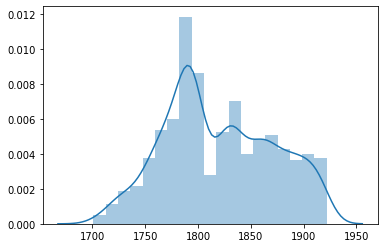

In [5]:
_ = sns.distplot(years)

There is a regular-looking increase in the number of volumes in the 18th century, which is explained by the fact that all these volumes were in the same subdirectory. Later periods are broken into numerous subdirectories corresponding to smaller and smaller ranges of time due to the increasing availability of data.

Let's see how many words occur how many times throughout the corpus.

In [6]:
all_words = pd.concat(docs).groupby('word').size().sort_values(ascending=False)
print('Number of words in loaded corpus:', len(all_words))

Number of words in loaded corpus: 1762105


Since this is quite a lot, we'll limit the vocabulary. We had reasonable results with the yearly aggregates, which had a vocabulary of size 10000, so we'll use the same vocabulary size here, keeping only the words that occur most frequently in the corpus.

In [7]:
vocab_size = 10_000
vocab = all_words.sort_values(ascending=False).head(vocab_size)
docs_cropped = [doc[doc['word'].isin(vocab.index)] for doc in docs]

Next, we tokenize the words.

In [8]:
%%time
token2word = dict(enumerate(vocab.index))
word2token = { v: k for k, v in token2word.items() }

for doc in docs_cropped:
    doc['token'] = doc['word'].map(word2token)

/home/ben/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


CPU times: user 43.7 s, sys: 620 ms, total: 44.3 s
Wall time: 44.3 s


Finally, we construct a document-word count matrix.

In [9]:
X = np.empty((len(docs_cropped), vocab_size))

for i, doc in enumerate(docs_cropped):
    X[i] = doc.set_index('token').reindex(range(len(vocab)))['freq'].fillna(0)

When working with yearly aggregate data, we normalized each row so that word counts were scaled by the total number of words counted in a year. We should do the same here, normalizing word counts by the number of words in a document. However, we go further this time and also weigh each word by its inverse document frequency to give more weight to words that are less common. Based on our observations regarding Zipf's law and logarithmic scaling when were analysing the yearly aggregate data, we logarithmically scale text frequencies here by setting `sublinear_tf=True`.

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(sublinear_tf=True)
X_tfidf = transformer.fit_transform(X)

Let's scale the data and try to fit a linear regression model.

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_tfidf.todense())
X_train, X_test, y_train, y_test = train_test_split(X_scaled, years, test_size=0.2)

reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.9177690142403356

## Can we do better?

We're still working with multicollinear data, for which ordinary least squares is typically unsuitable. There are various ways to overcome this problem.

### Regularization

As with yearly aggregate data, we make use of lasso regularization.

In [12]:
%%time
lasso = LassoCV(n_alphas=10, cv=3, n_jobs=-1)
lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)

CPU times: user 3min 55s, sys: 4.97 s, total: 4min
Wall time: 1min 28s


0.9269578670545847

We only see a small improvement.

### Ensemble methods

Let's try a different approach using random forests.

In [13]:
%%time
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

CPU times: user 13min 24s, sys: 899 ms, total: 13min 24s
Wall time: 13min 26s


0.9266993969481144

It's interesting to note how close the score of the random forest regressor is to that of the lasso regressor. Perhaps both models are essentially optimal for the data at hand.

### Neural networks

Perhaps a linear model is simply unsuitable for the task at hand. But what kinds of non-linearities should we expect? The power of neural networks is their ability to automatically adapt to non-linearities. It's worth trying out a few simple feedforward neural network architectures to determine just how far we can get with the available data.

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [ ]:
model = Sequential()

model.add(Dense(1, input_dim=10_000))

model.compile(optimizer='adam', loss='mse')

## From preprocessing to prediction

Preprocess, tokenize, vectorize, transform, densify, scale, predict.

In [14]:
nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)

In [15]:
def vector2text(x):
    return ' '.join([(token2word[t] + ' ') * int(n) for t, n in enumerate(x)])

In [16]:
def tok(string):
    return [str(t) for t in tokenizer(string)]

In [17]:
cv = CountVectorizer(vocabulary=word2token, tokenizer=tok)

In [18]:
x_new = cv.transform([vector2text(X[0, :])]).reshape(-1, 1)

In [19]:
(x_new - X[0, :].reshape(-1, 1)).sum()

60.0